In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from google.colab.patches import cv2_imshow
from tensorflow.keras import layers, Model

In [ ]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
CHANNELS = 3

In [ ]:
# Load SSIM scores
ssim_scores = pd.read_csv('/content/drive/MyDrive/metrics_scores_phase2.csv')
ssim_scores = ssim_scores[['Image', 'SSIM_Score']]

In [ ]:
ssim_scores

,Image,SSIM_Score
0,003image_1_4.bmp,0.887414
1,003image_1_2.bmp,0.782185
2,003image_1_6.bmp,0.712189
3,003image_1_5.bmp,0.725534
4,003image_1_3.bmp,0.768840
...,...,...
355,021image_5_4.bmp,0.992722
356,021image_5_6.bmp,0.933162
357,021image_5_7.bmp,0.502422
358,021image_5_9.bmp,0.869931


In [ ]:
base_path = '/content/drive/MyDrive/Phase2/Stimuli/separate'

In [ ]:
def load_dataset(base_path, ssim_scores):
    images_dict = {}
    labels_dict = {}
    ssim_dict = dict(zip(ssim_scores['Image'], ssim_scores['SSIM_Score']))

    for folder in os.listdir(base_path):
        folder_path = os.path.join(base_path, folder)
        if os.path.isdir(folder_path):
            images = []
            labels = []
            for file in os.listdir(folder_path):
                if file.endswith('.bmp'):
                    file_path = os.path.join(folder_path, file)
                    img = load_img(file_path, target_size=(IMAGE_HEIGHT, IMAGE_WIDTH))
                    img_array = img_to_array(img)
                    images.append(img_array)
                    if folder == 'Reference':
                        labels.append(1.0)
                    else:
                        label = ssim_dict.get(file, 0.0)
                        labels.append(label)
            images_dict[folder] = np.array(images)
            labels_dict[folder] = np.array(labels)

    return images_dict, labels_dict

In [ ]:
images_dict, labels_dict = load_dataset(base_path, ssim_scores)

In [ ]:
all_images = np.concatenate(list(images_dict.values()))
all_labels = np.concatenate(list(labels_dict.values()))

In [ ]:
def display_non_reference_images(images, labels, num_images=20):
    non_reference_images = [(img, label) for img, label in zip(images, labels) if label != 1.0]
    num_images = min(num_images, len(non_reference_images))
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        img, label = non_reference_images[i]
        plt.subplot(1, num_images, i+1)
        plt.imshow(img.astype("uint8"))
        plt.title(f"Label: {label:.2f}")
        plt.axis('off')
    plt.show()

In [ ]:
display_non_reference_images(all_images, all_labels, num_images=10)

In [ ]:
def split_images(images):
    left_images = images[:, :, :IMAGE_WIDTH//2, :]
    right_images = images[:, :, IMAGE_WIDTH//2:, :]
    return left_images, right_images

In [ ]:
def display_images(images, num_images=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].astype("uint8"))
        plt.axis('off')
    #plt.title(title)
    plt.show()

In [ ]:
display_images(all_images[:5])

In [ ]:
all_left, all_right = split_images(all_images)

In [ ]:
display_images(all_left[:5])
display_images(all_right[:5])

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(all_images, all_labels, test_size=0.2, random_state=101)

In [ ]:
train_left, train_right = split_images(train_images)
test_left, test_right = split_images(test_images)

In [ ]:
display_images(train_left[:5])
display_images(train_right[:5])

In [ ]:
!pip install pyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 30.8 MB/s eta 0:00:00


In [ ]:
import pywt

In [ ]:
train_left[0].shape

(224, 112, 3)

In [ ]:
def get_saliency_map_wavelet_rgb(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray_image = gray_image.astype(np.float32)
    height, width = gray_image.shape
    coeffs2 = pywt.dwt2(gray_image, 'haar')
    cA, (cH, cV, cD) = coeffs2
    cH = cv2.resize(cH, (width, height))
    cV = cv2.resize(cV, (width, height))
    cD = cv2.resize(cD, (width, height))
    saliency_map_channel = np.sqrt(cH**2 + cV**2 + cD**2)
    saliency_map = cv2.normalize(saliency_map_channel, None, 0, 255, cv2.NORM_MINMAX)
    return saliency_map.astype(np.uint8)

In [ ]:
salience_train_left = [get_saliency_map_wavelet_rgb(image) for image in train_left]
salience_train_right = [get_saliency_map_wavelet_rgb(image) for image in train_right]

In [ ]:
salience_test_left = [get_saliency_map_wavelet_rgb(image) for image in test_left]
salience_test_right = [get_saliency_map_wavelet_rgb(image) for image in test_right]

In [ ]:
salience_train_left[0].shape

(224, 112)

In [ ]:
salience_train_left_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(salience_train_left, axis=-1))
salience_train_right_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(salience_train_right, axis=-1))

In [ ]:
salience_train_left_rgb.shape

TensorShape([320, 224, 112, 3])

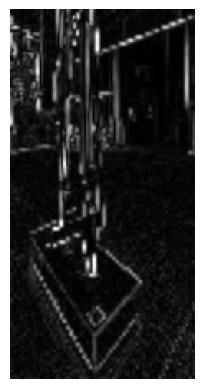

In [ ]:
image_to_display = salience_train_left_rgb[0].numpy() if isinstance(salience_train_left_rgb, tf.Tensor) else salience_train_left_rgb[0]
plt.imshow(image_to_display)
plt.axis('off')
plt.show()

In [ ]:
def display_salience_images(images,window_names=None):
    for i in range(len(images)):
        img = images[i]
        cv2_imshow(img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()

In [ ]:
display_images(train_left[:5])
display_images(salience_train_left[:5])

#MODEL

In [ ]:
input_shape = (224, 112, 3)

In [ ]:
def residual_block(x, filters, kernel_size=3, stride=1):
    shortcut = x
    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, kernel_size, strides=1, padding='same', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)

    # Adjust the shortcut path
    if stride != 1 or x.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', kernel_initializer='he_uniform')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.add([x, shortcut])
    x = layers.Activation('relu')(x)
    return x

In [ ]:
def build_feature_extractor_with_residuals(input_shape):
    input_layer = tf.keras.Input(shape=input_shape)

    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.3)(x)

    x = residual_block(x, 64, stride=2)
    x = residual_block(x, 64, stride=1)
    x = layers.Dropout(0.3)(x)

    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128, stride=1)
    x = layers.Dropout(0.3)(x)

    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256, stride=1)
    x = layers.Dropout(0.4)(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)

    return tf.keras.Model(inputs=input_layer, outputs=x)

In [ ]:
left_feature_extractor = build_feature_extractor_with_residuals(input_shape)
right_feature_extractor = build_feature_extractor_with_residuals(input_shape)

In [ ]:
def build_combined_model(left_feature_extractor, right_feature_extractor, input_shape):
    left_input = tf.keras.Input(shape=input_shape)
    right_input = tf.keras.Input(shape=input_shape)

    left_features = left_feature_extractor(left_input)
    right_features = right_feature_extractor(right_input)

    combined_features = layers.concatenate([left_features, right_features])
    combined_features = layers.Dense(1024, activation='relu')(combined_features)
    combined_features = layers.BatchNormalization()(combined_features)
    combined_features = layers.Dropout(0.5)(combined_features)

    combined_features = layers.Dense(512, activation='relu')(combined_features)
    combined_features = layers.BatchNormalization()(combined_features)
    combined_features = layers.Dropout(0.4)(combined_features)

    combined_features = layers.Dense(128, activation='relu')(combined_features)
    combined_features = layers.BatchNormalization()(combined_features)
    combined_features = layers.Dropout(0.3)(combined_features)

    output = layers.Dense(1, activation='sigmoid')(combined_features)

    model = tf.keras.Model(inputs=[left_input, right_input], outputs=output)
    return model

In [ ]:
combined_model = build_combined_model(left_feature_extractor, right_feature_extractor, input_shape)

In [ ]:
combined_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])

In [ ]:
combined_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 112, 3)]        0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 224, 112, 3)]        0         []                            
                                                                                                  
 model_4 (Functional)        (None, 256)                  2840928   ['input_11[0][0]']            
                                                                                                  
 model_5 (Functional)        (None, 256)                  2840928   ['input_12[0][0]']            
                                                                                            

In [ ]:
history = combined_model.fit(
    [salience_train_left_rgb, salience_train_right_rgb],
    train_labels,
    epochs=50,
    batch_size=32,
    validation_data=([salience_test_left_rgb, salience_test_right_rgb], test_labels)
)

Epoch 1/50
10/10 [==============================] - 31s 402ms/step - loss: 0.1676 - mae: 0.3250 - val_loss: 0.6136 - val_mae: 0.7650
Epoch 2/50
10/10 [==============================] - 3s 267ms/step - loss: 0.1439 - mae: 0.2951 - val_loss: 0.6136 - val_mae: 0.7650
Epoch 3/50
10/10 [==============================] - 2s 247ms/step - loss: 0.1196 - mae: 0.2640 - val_loss: 0.0837 - val_mae: 0.2350
Epoch 4/50
10/10 [==============================] - 2s 246ms/step - loss: 0.0878 - mae: 0.2243 - val_loss: 0.0837 - val_mae: 0.2350
Epoch 5/50
10/10 [==============================] - 2s 246ms/step - loss: 0.0707 - mae: 0.1961 - val_loss: 0.0837 - val_mae: 0.2350
Epoch 6/50
10/10 [==============================] - 2s 245ms/step - loss: 0.0657 - mae: 0.1920 - val_loss: 0.0837 - val_mae: 0.2350
Epoch 7/50
10/10 [==============================] - 2s 251ms/step - loss: 0.0646 - mae: 0.1867 - val_loss: 0.0837 - val_mae: 0.2350
Epoch 8/50
10/10 [==============================] - 3s 258ms/step - loss: 0

In [ ]:
test_loss, test_mae = combined_model.evaluate([salience_test_left_rgb, salience_test_right_rgb], test_labels)

3/3 [==============================] - 0s 50ms/step - loss: 0.1273 - mae: 0.3445


In [ ]:
test_predictions = combined_model.predict([salience_test_left_rgb, salience_test_right_rgb])

3/3 [==============================] - 1s 45ms/step


In [ ]:
plcc, srocc, rmse, krocc = calculate_metrics(test_labels, test_predictions.flatten())

print(f"PLCC: {plcc:.4f}")
print(f"SROCC: {srocc:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"KROCC: {krocc:.4f}")

PLCC: 0.8392
SROCC: 0.8470
RMSE: 0.3568
KROCC: 0.6655


In [ ]:
salience_train_left_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(salience_train_left, axis=-1))
salience_train_right_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(salience_train_right, axis=-1))
salience_test_left_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(salience_test_left, axis=-1))
salience_test_right_rgb = tf.image.grayscale_to_rgb(tf.expand_dims(salience_test_right, axis=-1))

In [ ]:
distortion_metrics = calculate_distortion_metrics(images_dict, labels_dict, combined_model)

2/2 [==============================] - 0s 442ms/step


<ipython-input-56-8bda4d08ea12>:2: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  plcc, _ = pearsonr(y_true, y_pred)
<ipython-input-56-8bda4d08ea12>:3: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  srocc, _ = spearmanr(y_true, y_pred)


3/3 [==============================] - 0s 38ms/step


In [ ]:
for distortion, metrics in distortion_metrics.items():
    plcc, srocc, rmse, krocc = metrics
    print(f"Distortion: {distortion}")
    print(f"  PLCC: {plcc:.4f}")
    print(f"  SROCC: {srocc:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  KROCC: {krocc:.4f}")
    print()

Distortion: Reference
  PLCC: nan
  SROCC: nan
  RMSE: 0.4201
  KROCC: nan

Distortion: White_Noise
  PLCC: 0.8263
  SROCC: 0.8694
  RMSE: 0.3972
  KROCC: 0.6768

Distortion: JPEG_2000
  PLCC: 0.8196
  SROCC: 0.8277
  RMSE: 0.3332
  KROCC: 0.6448

Distortion: JPEG
  PLCC: 0.6490
  SROCC: 0.7233
  RMSE: 0.4046
  KROCC: 0.5249

Distortion: Gaussian_Blur
  PLCC: 0.8957
  SROCC: 0.8939
  RMSE: 0.3092
  KROCC: 0.7410

Distortion: Fast_Fading
  PLCC: 0.8431
  SROCC: 0.8410
  RMSE: 0.3491
  KROCC: 0.6784



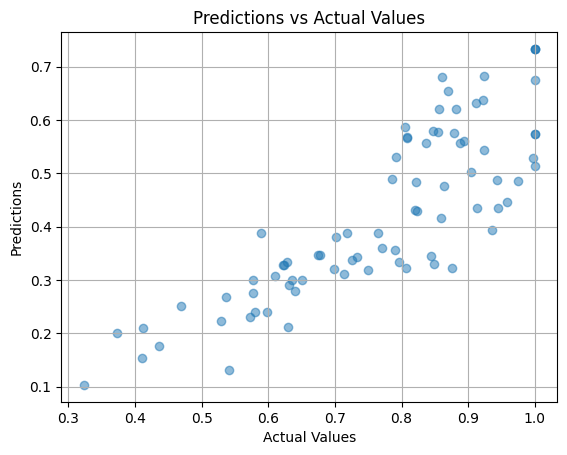

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(test_labels, test_predictions, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predictions')
plt.title('Predictions vs Actual Values')
plt.grid(True)
plt.show()


In [ ]:
combined_model.save('combined_model_phase2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
